Load Data

In [ ]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations

df = pd.read_csv('/content/drive/MyDrive/ML_Data/human_suicide_risks.csv', sep=',')

print(df.shape)
df.head()

Mounted at /content/drive
(500, 8)


,ID,Gender,Mental_Health_Issue,Substance_Abuse,Previous_Attempts,Abuse History,Social Isolation,Financial Problem
0,1,Male,No,No,Yes,No,Yes,Yes
1,2,Male,Yes,Yes,No,No,No,No
2,3,Female,Yes,Yes,No,Yes,Yes,Yes
3,4,Male,Yes,Yes,Yes,No,No,Yes
4,5,Female,Yes,Yes,No,Yes,Yes,Yes


# Step 1: Prepare transactions

>



In [ ]:
def prepare_transactions(data, columns):
    """
    Convert selected columns of a DataFrame into a list of transactions.
    """
    transactions = data[columns].apply(lambda row: [col for col in columns if row[col] == 'Yes'], axis=1).tolist()
    return transactions

selected_columns = ['Mental_Health_Issue', 'Substance_Abuse', 'Previous_Attempts',
                    'Abuse History', 'Social Isolation', 'Financial Problem']
transactions = prepare_transactions(df, selected_columns)


# Step 2: FP-Growth Algorithm


In [ ]:
class FPNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.link = None

class FPTree:
    def __init__(self, transactions, min_support):
        self.min_support = min_support
        self.header_table = {}
        self.root = FPNode(None, 1, None)
        self._build_tree(transactions)

    def _build_tree(self, transactions):
        # Count item frequencies
        item_counts = {}
        for transaction in transactions:
            for item in transaction:
                item_counts[item] = item_counts.get(item, 0) + 1

        # Filter items by min_support
        self.header_table = {item: [count, None] for item, count in item_counts.items() if count >= self.min_support}
        if not self.header_table:
            return

        # Sort items in each transaction by frequency
        for transaction in transactions:
            sorted_items = [item for item in sorted(transaction, key=lambda x: (-item_counts[x], x)) if item in self.header_table]
            self._insert_tree(sorted_items, self.root)

    def _insert_tree(self, items, node):
        if not items:
            return

        first_item = items[0]
        if first_item in node.children:
            node.children[first_item].count += 1
        else:
            new_node = FPNode(first_item, 1, node)
            node.children[first_item] = new_node

            if self.header_table[first_item][1] is None:
                self.header_table[first_item][1] = new_node
            else:
                current = self.header_table[first_item][1]
                while current.link is not None:
                    current = current.link
                current.link = new_node

        self._insert_tree(items[1:], node.children[first_item])

    def mine_patterns(self):
        patterns = {}
        for item, (count, node) in self.header_table.items():
            conditional_patterns = []
            while node is not None:
                path = []
                parent = node.parent
                while parent is not None and parent.item is not None:
                    path.append(parent.item)
                    parent = parent.parent
                path.reverse()
                for _ in range(node.count):
                    conditional_patterns.append(path)
                node = node.link

            # Recursively mine conditional tree
            conditional_tree = FPTree(conditional_patterns, self.min_support)
            conditional_patterns = conditional_tree.mine_patterns()
            for pattern, freq in conditional_patterns.items():
                patterns[tuple([item] + list(pattern))] = freq

            patterns[(item,)] = count
        return patterns


# Step 3: Generate Association Rules


In [ ]:
def generate_association_rules_fp(patterns, min_confidence, transactions):
    rules = []
    transaction_count = len(transactions)
    for itemset, support in patterns.items():
        for i in range(1, len(itemset)):
            antecedents = list(combinations(itemset, i))
            for antecedent in antecedents:
                consequent = tuple(set(itemset) - set(antecedent))
                antecedent_support = patterns.get(tuple(sorted(antecedent)), 0)
                if antecedent_support > 0:
                    confidence = support / antecedent_support
                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, support / transaction_count, confidence))
    return rules

# Step 4: Visualization Functions


In [ ]:
def plot_network_graph_fp(rules):
    G = nx.DiGraph()
    for rule in rules:
        antecedent, consequent, _, confidence = rule
        G.add_edge(', '.join(antecedent), ', '.join(consequent), weight=confidence)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
            font_size=10, font_weight='bold', arrowsize=20)
    plt.title('Association Rules Network')
    plt.show()



def plot_heatmap_fp(rules):
    heatmap_data = pd.DataFrame(rules, columns=["Antecedent", "Consequent", "Support", "Confidence"])

    heatmap_table = heatmap_data.pivot_table(
        index="Antecedent",
        columns="Consequent",
        values="Confidence",
        fill_value=0
    )
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Confidence'})
    plt.title("Heatmap of Association Rules (Confidence)")
    plt.xlabel("Consequent")
    plt.ylabel("Antecedent")
    plt.show()


# Example Execution

In [ ]:
min_support = 0.25 * len(transactions)
min_confidence = 0.5
fp_tree = FPTree(transactions, min_support)
patterns = fp_tree.mine_patterns()
rules_fp = generate_association_rules_fp(patterns, min_confidence, transactions)

filtered_patterns = {itemset: support for itemset, support in patterns.items() if support / len(transactions) >= 0.2}
filtered_rules = [rule for rule in rules_fp if rule[3] >= min_confidence]

print("Frequent Itemsets (min_support >= {:.2f}):".format(0.25))
print(filtered_patterns)
print("\nAssociation Rules (min_confidence >= {:.2f}):".format(min_confidence))
for rule in filtered_rules:
    antecedent, consequent, support, confidence = rule
    print(f"{antecedent} => {consequent} (Support: {support:.2f}, Confidence: {confidence:.2f})")

Frequent Itemsets (min_support >= 0.25):
{('Previous_Attempts', 'Financial Problem'): 133, ('Previous_Attempts', 'Substance_Abuse'): 134, ('Previous_Attempts',): 259, ('Social Isolation', 'Financial Problem'): 130, ('Social Isolation', 'Previous_Attempts'): 139, ('Social Isolation', 'Substance_Abuse'): 128, ('Social Isolation', 'Abuse History'): 129, ('Social Isolation',): 250, ('Financial Problem',): 266, ('Mental_Health_Issue', 'Substance_Abuse'): 125, ('Mental_Health_Issue',): 231, ('Substance_Abuse', 'Financial Problem'): 141, ('Substance_Abuse',): 260, ('Abuse History', 'Financial Problem'): 139, ('Abuse History', 'Substance_Abuse'): 127, ('Abuse History', 'Previous_Attempts'): 132, ('Abuse History',): 254}

Association Rules (min_confidence >= 0.50):
('Previous_Attempts',) => ('Financial Problem',) (Support: 0.27, Confidence: 0.51)
('Financial Problem',) => ('Previous_Attempts',) (Support: 0.27, Confidence: 0.50)
('Previous_Attempts',) => ('Substance_Abuse',) (Support: 0.27, Conf

# Visualize the results


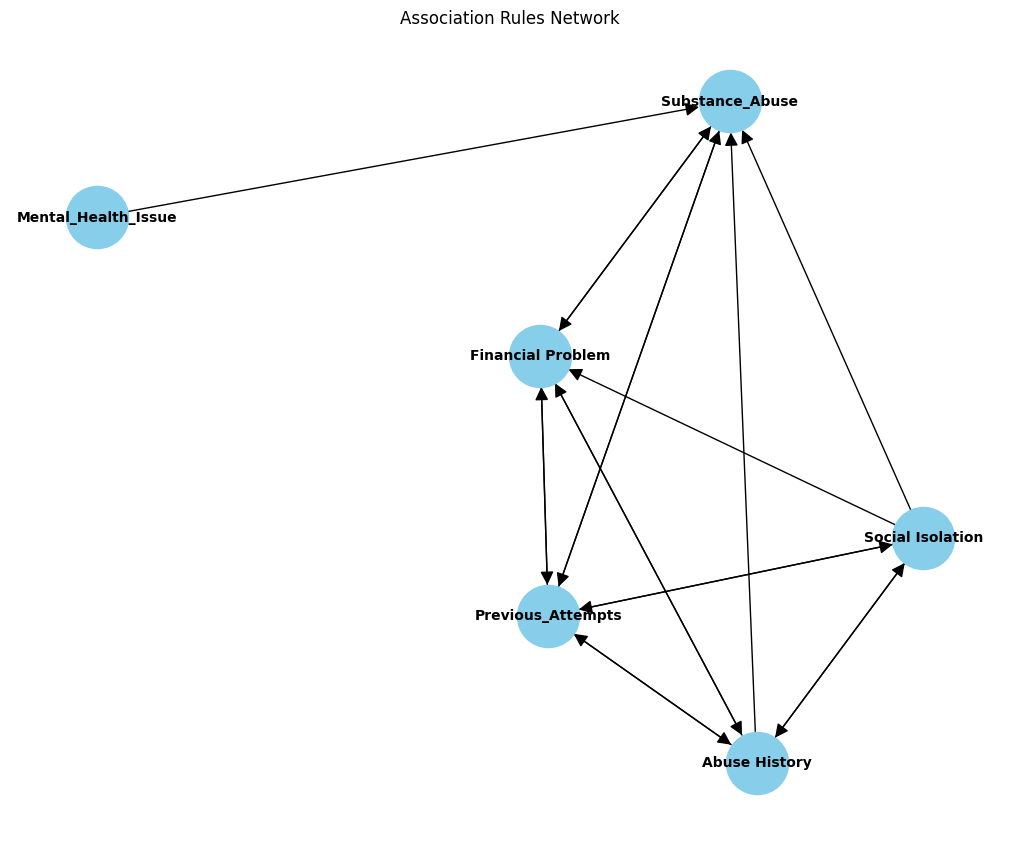

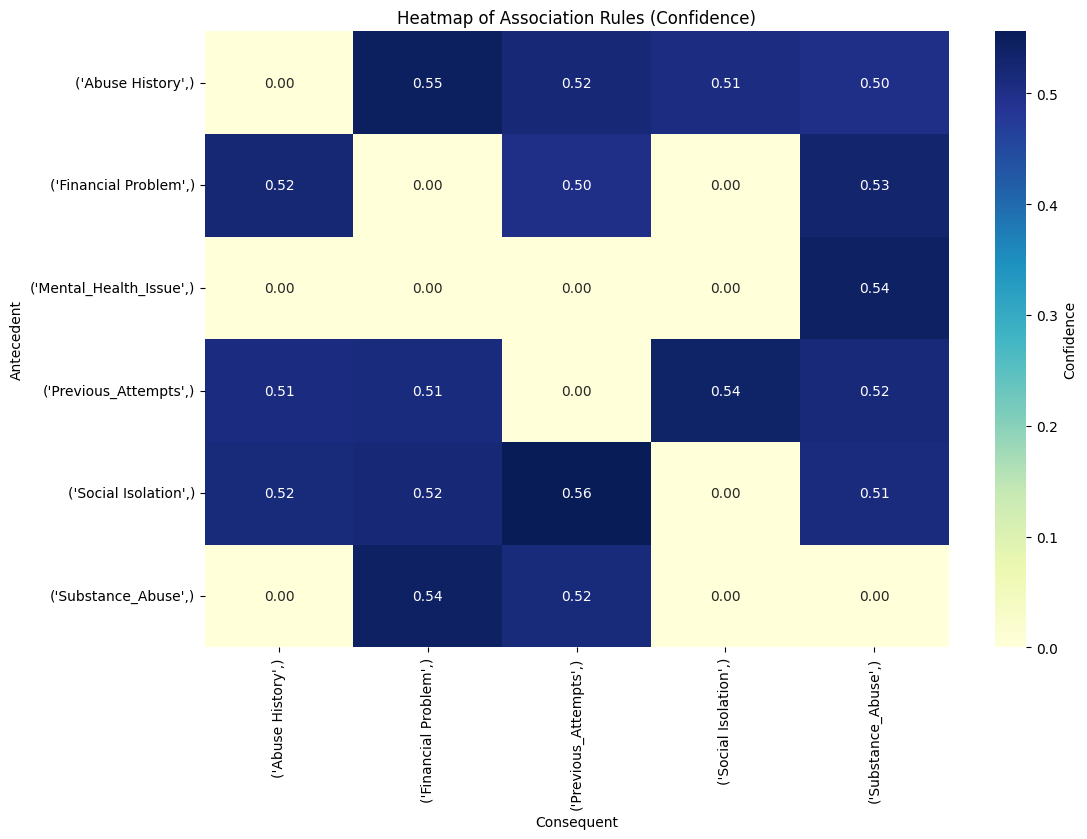

In [ ]:
plot_network_graph_fp(rules_fp)
plot_heatmap_fp(rules_fp)
